In [1]:
!nvidia-smi

Sat Mar 23 09:08:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |     80MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [3]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy
import torch

## Prepare for loging

In [4]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path


from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [5]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/resnet34-fastai/004.23-03-2019-08-33'

In [53]:
model_save_dir

'train_log/resnet34-fastai/004.23-03-2019-08-33'

In [6]:
print(f"""
Note for version {version} model {MODEL_NAME}:

""")


Note for version 4 model resnet34-fastai:




### Init data loader

In [7]:
data_path = '/home/qnkhuat/data/emotion_compilation_split'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=256)
       .normalize())

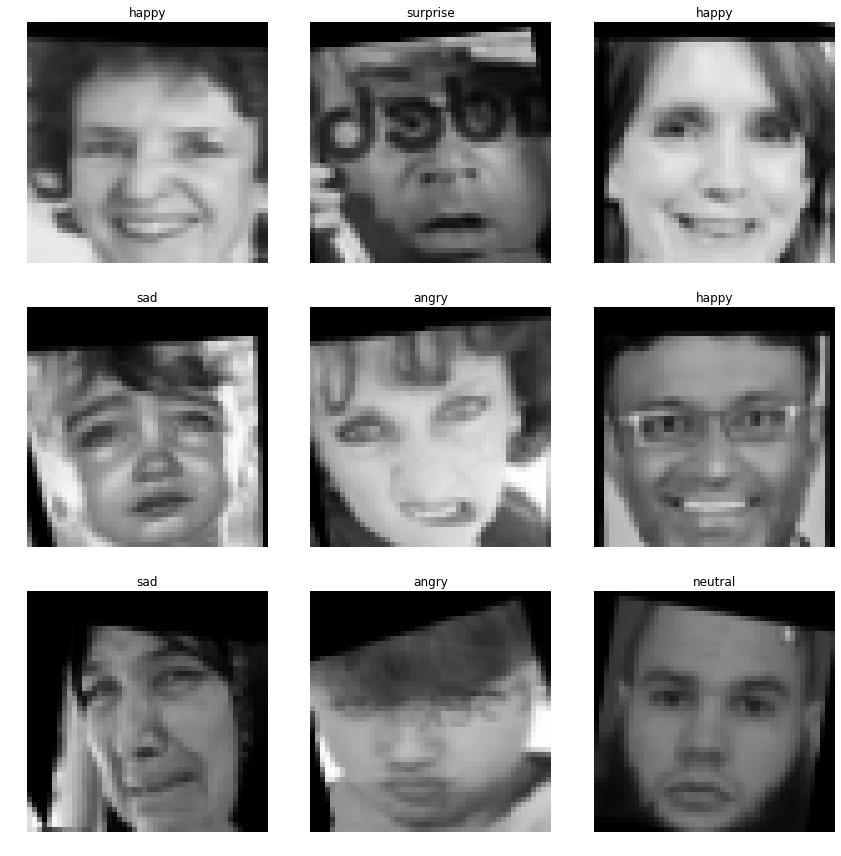

In [8]:
data.show_batch(rows=3)

## Init model

In [9]:
model = models.resnet34

In [10]:
learn = cnn_learner(data, model)

In [11]:
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


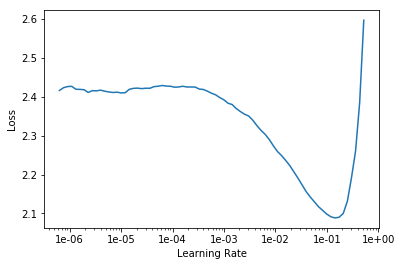

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr=5e-2

In [14]:
learn.metrics = [accuracy]

## Start training

In [15]:
learn.fit_one_cycle(12,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.590412,1.390929,0.482967,00:15
1,1.360677,1.226261,0.582866,00:16
2,1.164626,0.988293,0.653155,00:15
3,1.055627,0.936118,0.675147,00:17
4,0.998656,1.012790,0.669398,00:15
5,0.941983,0.834635,0.706339,00:15
6,0.888850,0.829571,0.709501,00:15
7,0.853713,0.781151,0.725169,00:14
8,0.814629,0.743387,0.735231,00:16
9,0.787386,0.720281,0.743136,00:15


In [16]:
#learn.fit(12,lr)

In [17]:
learn.save('stage-1')

#### Unfreeze 

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


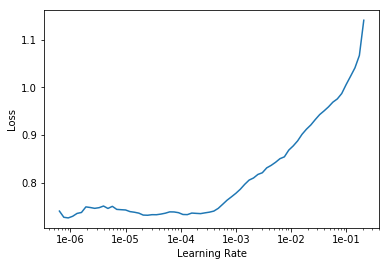

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr=1e-5

In [21]:
learn.fit(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.797452,0.793336,0.719419,00:16
1,0.717911,0.659181,0.761823,00:17
2,0.670782,0.660766,0.756360,00:17
3,0.619398,0.688841,0.755354,00:15
4,0.589937,0.612133,0.776484,00:15
5,0.558940,0.622008,0.782809,00:16
6,0.537557,0.582671,0.789421,00:16
7,0.511766,0.590984,0.795170,00:15
8,0.498478,0.572851,0.794595,00:18
9,0.485195,0.551831,0.801207,00:16


In [22]:
learn.save('stage-2')

#### Refreeze

In [23]:
learn.freeze()

In [24]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,accuracy,time
0,0.374530,0.517808,0.816588,00:17
1,0.364428,0.508614,0.822050,00:15
2,0.353095,0.504138,0.824350,00:15
3,0.347159,0.502995,0.827943,00:15
4,0.340775,0.505558,0.821762,00:15
5,0.332357,0.503474,0.826218,00:17
6,0.321977,0.509114,0.827512,00:15
7,0.323857,0.508357,0.824925,00:15
8,0.323343,0.504579,0.828374,00:15


In [25]:
learn.save('stage-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


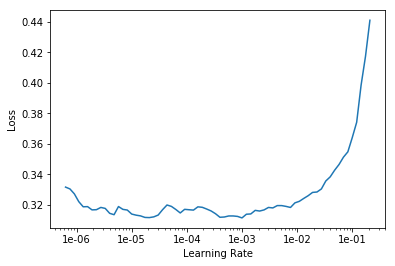

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit(10,lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.327201,0.505589,0.828518,00:17
1,0.330235,0.505251,0.828087,00:15
2,0.329866,0.508354,0.825787,00:17
3,0.327055,0.504551,0.827799,00:15
4,0.322175,0.506359,0.826362,00:15
5,0.316272,0.505648,0.829380,00:16
6,0.326013,0.505405,0.826506,00:15
7,0.324857,0.504253,0.829380,00:15
8,0.327200,0.505125,0.829524,00:15
9,0.326367,0.505868,0.826362,00:15


In [28]:
learn.save('stage-5')

In [34]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

Traceback (most recent call last):
  File "/home/qnkhuat/miniconda3/envs/dev/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/qnkhuat/miniconda3/envs/dev/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/qnkhuat/miniconda3/envs/dev/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/qnkhuat/miniconda3/envs/dev/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

# Remember to save the checkpoint before run this

In [50]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:4]+'.html'
os.system(f"jupyter nbconvert {NB_NAME} --output {nb_name}")

content = f'{version} - {str(tta)[:4]}'
with open(f'{pjoin(TRAIN_LOG_DIR,MODEL_NAME)}/{NB_NAME}.txt','a') as f :
    f.write(content)
    f.writelines(NOTE)

This notebook has been saved


'train_log/resnet34-fastai/004.23-03-2019-08-33'